In [1]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import h5py
import copy
import time
%pdb on

class StandardScaler(object):
    def __init__(self):
        pass

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X - self.mean, axis=0)
        return self

    def transform(self, X):
        return (X - self.mean) / self.std

    def fit_transform(self, X):
        return self.fit(X).transform(X)

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return (1.0 / (1.0 + np.exp(-x)))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  (a * (1 - a ))
    
    def __softmax(self, x):
        y = np.atleast_2d(x)
        axis = -1
        y = y - np.expand_dims(np.max(y, axis = axis), axis)
        y = np.exp(y)
        summ = np.expand_dims(np.sum(y, axis = axis), axis)
        out = y / summ
        if len(x.shape) == 1: out = out.flatten()    
        return out
    
    def __softmax_deriv(self, a):
        "applies softmax derivative over the given array"
        return a * (1 - a)
    
    def __ReLU(self,x):
        """applies relu activation"""
        return x * (x > 0)
    
    def __ReLU_deriv(self,a):
        """returns derivative of relu activation"""
        return 1 * (a > 0)
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == 'ReLU':
            self.f = self.__ReLU
            self.f_deriv = self.__ReLU_deriv
            
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', dropout=None, W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        self.dropout=dropout
        self.dropout_vector = None
        self.gamma = np.ones((1,n_out))
        self.beta = np.ones((1,n_out))
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        if activation == 'logistic':
            self.W *= 4

        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        self.vel_W = np.zeros(self.W.shape)
        self.vel_b = np.zeros(self.b.shape)
        
    def forward(self, input, mode):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        if mode=='train':
  
            lin_output = np.dot(input, self.W) + self.b
                
            self.output = (
                lin_output if self.activation is None
                else self.activation(lin_output)
                )
                
            if self.dropout:
                self.dropout_vector = np.random.binomial(1, 1-self.dropout, size=self.output.shape[-1])/(1-self.dropout)
                self.output = self.output * self.dropout_vector
            
        else:                
            lin_output = np.dot(input, self.W) + self.b
            
            self.output = (
                lin_output if self.activation is None
                else self.activation(lin_output)
                )
                
        self.input=input

        return self.output
    
    def backward(self, delta, output_layer=False):
        
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        
        if self.dropout: self.dropout_vector*self.grad_W
            
        self.grad_b = np.sum(delta,axis=0)
        
        if self.activation_deriv: delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
            
        return delta

class MLP:
    """
    """      
    def __init__(self, layers, activation=[None,'tanh','tanh'], dropout=None):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        self.mode = 'train'
        self.activation=activation
        self.dropout=dropout
        self.batch_size = 1
        self.weight_decay = 0
        
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1],self.dropout[i]))
            
    def train(self):
        """
        sets network mode to train, enables dropout
        """
        self.mode = 'train'
    
    def test(self):
        """
        sets network mode to train, disables dropout
        """
        self.mode = 'test'

    def forward(self,input):
        """
        main forward step that triggers consecutive forward steps in each layer
        :param input: array of inputs
        :returns output: resulting output from all forward passes
        """
        for layer in self.layers:
            output=layer.forward(input=input, mode=self.mode)
            input=output
        return output

    def criterion_MSE(self,y,y_hat):
        """
        Criterion that uses Cross Entropy Loss Function 
        on actual and predicted labels and returns loss and delta
        :param y: actual target labels
        :param y_hat: predicted target labels
        """
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        error = y-y_hat
        loss=error**2
        # calculate the delta of the output layer
        delta=-error*activation_deriv(y_hat)
        # return loss and delta
        return loss,delta
    
    def criterion_CELoss(self,y,y_hat):
        """
        Criterion that uses Cross Entropy Loss Function 
        on actual and predicted labels and returns loss and delta
        :param y: actual target labels
        :param y_hat: predicted target labels
        """
        error = y * np.log(y_hat)
        loss = -np.sum(error)
        delta = y_hat-y
        return loss,delta
        
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)
            
    def update(self,lr):
        """
        Update step that uses layer gradients and learning rate
        """
        for layer in self.layers:
            if self.momentum!=0:
                layer.vel_W = layer.vel_W * self.momentum + layer.grad_W * self.lr
                layer.vel_b = layer.vel_b * self.momentum + layer.grad_b * self.lr
                
                layer.W -= (layer.vel_W + layer.W * self.weight_decay)
                layer.b -= (layer.vel_b + layer.b * self.weight_decay)
            else:
                layer.W -= (lr * layer.grad_W + layer.W * self.weight_decay)
                layer.b -= (lr * layer.grad_b + layer.b * self.weight_decay)
            
    def get_batches(self,X, y, batch_size):
        """
        Shuffles and splits inputs X,y into batches and returns a list of batches
        :param X: Input data or features
        :param y: Input targets
        :param batch_size: Requested size for batches to be returned
        
        """
        batches = []

        X, y = self.shuffle(X, y)

        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]
            
            batches.append((X_batch, y_batch))

        return batches

    def fit(self,X,y,learning_rate=0.1, epochs=10, batch_size=1, momentum=0, weight_decay=0):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        self.batch_size=batch_size
        self.momentum = momentum
        self.lr = learning_rate
        self.weight_decay = weight_decay
        
        X=np.array(X)
        y=np.array(y)
        epoch_av_loss = np.zeros(epochs)
        y_dummies = np.array(pd.get_dummies(y))
        
        self.train()
        
        # Differentiate Stochastic Gradient Descent vs Batch Gradient Descent
        if batch_size>1:
            batches = self.get_batches(X, y_dummies, batch_size)
            for k in range(epochs):
                losses = []
                for X_batch,y_dummies in batches:
                    # forward pass
                    y_hat = self.forward(X_batch)
                    
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        loss,delta=self.criterion_CELoss(y_dummies,y_hat)
                    else:
                        loss,delta=self.criterion_MSE(y_dummies,y_hat)
                    
                    losses.append(loss)
                    self.backward(delta)
                    
                    # update
                    self.update(learning_rate)
                epoch_av_loss[k] = np.sum(losses)/X.shape[0]
        else:
            for k in range(epochs):
                loss=np.zeros(X.shape[0])
                for it in range(X.shape[0]):
                    i=np.random.randint(X.shape[0])
                    # forward pass
                    y_hat = self.forward(X[i])
                
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        loss[it],delta=self.criterion_CELoss(y_dummies[i],y_hat)
                    else:
                        loss[it],delta=self.criterion_MSE(y_dummies[i],y_hat)
                
                    self.backward(delta)

                    # update
                    self.update(learning_rate)
                epoch_av_loss[k] = np.sum(loss)/X.shape[0]
        return epoch_av_loss
    
    def shuffle(self, x,y):
        """
        shuffles given input and target variables of same first axis shape
        :returns x,y: shuffled input and target
        """
        idxs = [idx for idx in range(x.shape[0])]
        np.random.shuffle(idxs)
        return x[idxs], y[idxs]

    def predict(self, x):
        """
        predict target variables based on inputs
        :returns yhat: an array of predictions
        """
        self.test()
        x = np.array(x)
        yhat = self.forward(x)
        if self.activation[-1]=='softmax':
            yhat = np.argmax(yhat,axis=1)
        return yhat
    
    def model_checkpointer(self, X, y, learning_rate=0.001, test_size=0.25, batch_size=1,epochs=10, momentum=0, weight_decay=0, verbose=True):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """
        self.best_accuracy = 0
        self.best_model = None
        self.batch_size=batch_size
        self.momentum = momentum
        self.lr = learning_rate
        self.weight_decay = weight_decay
        
        self.train()
        X=np.array(X)
        y=np.array(y)
        y_dummies = np.array(pd.get_dummies(y))
        X_train, X_val, y_train, y_val = train_test_split(X, y_dummies, test_size=test_size, shuffle=True)
        scaler = StandardScaler()
        #scaler = Normalizer()
        #scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        epoch_av_loss = np.zeros(epochs)
        accuracies_val = []
        accuracies_test = []
        if batch_size>1:
            batches = self.get_batches(X_train, y_train, batch_size)
            for k in range(epochs):
                losses = []
                
                self.test()
                yhat_train = self.forward(X_train)
                yhat_val = self.forward(X_val)
                # Calculate train and Test Accuracy
                accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
                accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
                
                self.train()
                for X_batch,y_dummies in batches:
                    # forward pass
                    y_hat = self.forward(X_batch)
                    
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        loss,delta=self.criterion_CELoss(y_dummies,y_hat)
                    else:
                        loss,delta=self.criterion_MSE(y_dummies,y_hat)
                    
                    losses.append(loss)                      
                    self.backward(delta)
                    
                    # update
                    self.update(learning_rate)
                losses[k] = np.sum(loss)/X_train.shape[0]
                self.test()
                yhat_train = self.forward(X_train)
                yhat_val = self.forward(X_val)
                # Calculate train and Test Accuracy
                accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
                accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
                accuracies_val.append(accuracy_train)
                accuracies_test.append(accuracy_val)
                if verbose:
                    print('Epoch: {}..\ntrain Accuracy: {} \nValidation Accuracy: {} \nLoss: {} \n'.
                          format(k, accuracy_train, accuracy_val, losses[k]))
                    
                if accuracy_val > self.best_accuracy:
                    self.best_accuracy = accuracy_val
                    self.best_model = copy.deepcopy(self)
        else:
            for k in range(epochs):
                loss = np.zeros(X_train.shape[0])
                self.test()
                yhat_train = self.forward(X_train)
                yhat_val = self.forward(X_val)
                # Calculate train and Test Accuracy
                accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
                accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
                self.train()
                for it in range(X_train.shape[0]):
                    i=np.random.randint(X_train.shape[0])
                
                    # forward pass
                    y_hat = self.forward(X_train[i])
                
                    # backward pass
                    if self.activation[-1] == 'softmax':
                        loss[it],delta=self.criterion_CELoss(y_train[i],y_hat)
                    else:
                        loss[it],delta=self.criterion_MSE(y_train[i],y_hat)
                
                    self.backward(delta)

                    # update
                    self.update(learning_rate)
                
                self.test()
                yhat_train = self.forward(X_train)
                yhat_val = self.forward(X_val)
                # Calculate train and Test Accuracy
                accuracy_train = (np.sum(np.argmax(np.array(y_train),axis=1)==np.argmax(yhat_train,axis=1)))/(y_train.shape[0])
                accuracy_val = (np.sum(np.argmax(np.array(y_val),axis=1)==np.argmax(yhat_val,axis=1)))/(y_val.shape[0])
                accuracies_val.append(accuracy_train)
                accuracies_test.append(accuracy_val)
                
                if accuracy_val > self.best_accuracy:
                    self.best_accuracy = accuracy_val
                    self.best_model = copy.deepcopy(self)
                
                epoch_av_loss[k] = np.sum(loss)/X_train.shape[0]

                if verbose:
                    print('Epoch: {}..\ntrain Accuracy: {} \nValidation Accuracy: {} \nLoss: {} \n'.
                          format(k, accuracy_train, accuracy_val, np.mean(loss)))
                    
        return epoch_av_loss, accuracies_val, accuracies_test

Automatic pdb calling has been turned ON


## FIT REQUESTED PARAMETERS ONLY

In [ ]:
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

X=np.array(data)
y=np.array(label)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.8, shuffle=True)
scaler = StandardScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
mlp = MLP([128,128,128,128,10],activation=[None,'logistic','logistic','logistic','softmax'], dropout=[0.0, 0.0, 0.0, 0.0, 0.0])

mlp.fit(X_train, y_train, learning_rate=0.001, batch_size=100, momentum=0.9, weight_decay=0.000, epochs=10)
predictions = mlp.predict(X_val)
#predictions.to_csv('output/Predicted_labels.h5')
print('Accuracy for these settings : {}'.format((predictions==y_val).mean()))

with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = predictions)

Accuracy for these settings : 0.8302916666666667


## Split into train and validation sets, use cross validation to optimize parameters, then refit to whole data, predict test data and save into .h5 file.

## Sigmoid Architecture

C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:238: RuntimeWarning: divide by zero encountered in log
C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in multiply


Epoch: 0..
train Accuracy: 0.4071111111111111 
Validation Accuracy: 0.406 
Loss: 0.0019452359118791805 

Epoch: 1..
train Accuracy: 0.5537777777777778 
Validation Accuracy: 0.5316666666666666 
Loss: 0.0016308559678410472 

Epoch: 2..
train Accuracy: 0.7143333333333334 
Validation Accuracy: 0.696 
Loss: 0.001383900740397021 

Epoch: 3..
train Accuracy: 0.7558888888888889 
Validation Accuracy: 0.7326666666666667 
Loss: nan 

Epoch: 4..
train Accuracy: 0.7953333333333333 
Validation Accuracy: 0.765 
Loss: nan 

Epoch: 5..
train Accuracy: 0.8156666666666667 
Validation Accuracy: 0.7883333333333333 
Loss: nan 

Epoch: 6..
train Accuracy: 0.8235555555555556 
Validation Accuracy: 0.7926666666666666 
Loss: nan 

Epoch: 7..
train Accuracy: 0.8447777777777777 
Validation Accuracy: 0.806 
Loss: nan 

Epoch: 8..
train Accuracy: 0.8407777777777777 
Validation Accuracy: 0.7943333333333333 
Loss: nan 

Epoch: 9..
train Accuracy: 0.8573333333333333 
Validation Accuracy: 0.8003333333333333 
Loss: 0.000

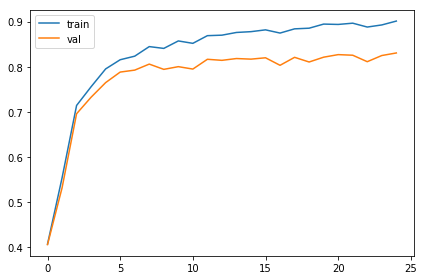

In [ ]:
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

X=np.array(data)
y=np.array(label)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.8, shuffle=True)
scaler = StandardScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

mlp = MLP([128, 64, 32, 10],activation=[None,'logistic', 'logistic', 'softmax'], dropout=[0.1, 0.1, 0.1, 0])

start = time.time()
losses, accuracies_train, accuracies_val = mlp.model_checkpointer(X_train, y_train, learning_rate=0.001, batch_size=32, momentum=0.9, weight_decay=0.0, epochs=25)
end = time.time()

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_val, label='val')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_logistic.png')

print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.predict(scaled_test_data)

with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

## Relu Architecture [128,64,32,10] Dropout = 0.1, Batch_Size =16, LR=0.001, momentum=25, epochs=25

In [ ]:
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

X=np.array(data)
y=np.array(label)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.8, shuffle=True)
scaler = StandardScaler()
#scaler = Normalizer()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

mlp = MLP([128, 64, 32, 10],activation=[None,'ReLU', 'ReLU', 'softmax'], dropout=[0.1, 0.1, 0.1, 0])

start = time.time()

losses, accuracies_train, accuracies_val = mlp.model_checkpointer(X_train, y_train, learning_rate=0.0001 , batch_size=16, momentum=0.9, weight_decay=0.0, epochs=25)

end = time.time()

print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_val, label='val')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_logistic.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.best_model.predict(scaled_test_data)

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:238: RuntimeWarning: divide by zero encountered in log
C:\Users\dnuho\Anaconda3\envs\data\lib\site-packages\ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in multiply


Epoch: 0..
train Accuracy: 0.6464444444444445 
Validation Accuracy: 0.626 
Loss: nan 

Epoch: 1..
train Accuracy: 0.7947777777777778 
Validation Accuracy: 0.7726666666666666 
Loss: nan 

Epoch: 2..
train Accuracy: 0.836 
Validation Accuracy: 0.8083333333333333 
Loss: nan 

Epoch: 3..
train Accuracy: 0.8495555555555555 
Validation Accuracy: 0.8153333333333334 
Loss: nan 

Epoch: 4..
train Accuracy: 0.8656666666666667 
Validation Accuracy: 0.8193333333333334 
Loss: nan 

Epoch: 5..
train Accuracy: 0.8682222222222222 
Validation Accuracy: 0.8223333333333334 
Loss: nan 



## %87.3 Accuracy Relu Architecture [128,64,32,10] Dropout = 0.0, Batch_Size =16, LR=0.001, epochs=25

In [ ]:
import time
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

mlp = MLP([128, 64, 32, 10],activation=[None, 'ReLU', 'ReLU','softmax'], dropout=[0.0, 0.0, 0.0, 0])

start = time.time()

losses, accuracies_train, accuracies_test = mlp.model_checkpointer(data, label, batch_size=16, momentum=0.9, learning_rate=0.0001,epochs=25)

end = time.time()
print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='validation')
plt.tight_layout()
plt.legend()
plt.savefig('accuracy_relu_dropout0.1.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.best_model.predict(scaled_test_data)

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

## %89 Accuracy Relu Architecture [128,64,32,10] Dropout = 0.1, Batch_Size =32, LR=0.001, epochs=15

In [ ]:
import time
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

mlp = MLP([128, 256, 64, 10],activation=[None, 'ReLU', 'ReLU','softmax'], dropout=[0.1, 0.1, 0.0, 0])

start = time.time()

losses, accuracies_train, accuracies_test = mlp.model_checkpointer(data, label, batch_size=32, momentum=0.9, learning_rate=0.0001,epochs=80)

end = time.time()
print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

ax.plot(accuracies_train, label='train')
ax.plot(accuracies_test, label='validation')
ax.tight_layout()
ax.legend()
plt.set_xlabel('Epochs')
plt.set_ylabel('Accuracy')
ax.savefig('accuracy_relu_dropout0.1.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.best_model.predict(scaled_test_data)

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

In [ ]:
import time
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

mlp = MLP([128, 256, 64, 10],activation=[None, 'ReLU', 'ReLU','softmax'], dropout=[0.2, 0.2, 0.0, 0])

start = time.time()

losses, accuracies_train, accuracies_test = mlp.model_checkpointer(data, label, batch_size=32, momentum=0.9, learning_rate=0.0001,epochs=80)

end = time.time()
print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='validation')
plt.tight_layout()
plt.legend()
plt.set_xlabel('Epochs')
plt.set_ylabel('Accuracy')
plt.savefig('accuracy_relu_dropout0.1.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.best_model.predict(scaled_test_data)

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)

In [ ]:
import time
with h5py.File('input/train_128.h5','r') as H:
    data = np.copy(H['data'])
with h5py.File('input/train_label.h5','r') as H:
    label = np.copy(H['label'])

mlp = MLP([128, 256, 64, 10],activation=[None, 'ReLU', 'ReLU','softmax'], dropout=[0.3, 0.3, 0.0, 0])

start = time.time()

losses, accuracies_train, accuracies_test = mlp.model_checkpointer(data, label, batch_size=32, momentum=0.9, learning_rate=0.0001,epochs=80)

end = time.time()
print('Time taken to train and predict: {:.2f} seconds'.format(end-start))
print('Best accuracy achieved: {:.3f} accuracy'.format(mlp.best_accuracy))

plt.plot(accuracies_train, label='train')
plt.plot(accuracies_test, label='validation')
plt.tight_layout()
plt.legend()
plt.set_xlabel('Epochs')
plt.set_ylabel('Accuracy')
plt.savefig('accuracy_relu_dropout0.1.png')

# READ TEST DATA
with h5py.File('input/test_128.h5','r') as H:
    test_data = np.copy(H['data'])
    
scaler = StandardScaler().fit(data)
scaled_test_data = scaler.transform(test_data)
test_predictions = mlp.best_model.predict(scaled_test_data)

# WRITE PREDICTIONS
with h5py.File('output/Predicted_labels.h5','w') as hdf:
    hdf.create_dataset('labels', data = test_predictions)